# ETSpy Demo

This notebook demonstrates the basic use and functionality of the ETSpy package.

It covers:
* Loading simulated data
* Basic plotting of tilt series data
* Reconstruction of single slices of simulated data
* Reconstruction of the full simluated dataset
* Saving reconstructed data

If you are viewing this demo on the ETSpy documentation website, it will not be interactive. We recommend downloading the latest version of the demo from [Github](https://github.com/usnistgov/etspy/tree/master/docs/examples/etspy_demo.ipynb) and running it on your local machine.

## Imports
For interactive plotting, we set the Matplotlib backend to `widget`.

In addition to the `etspy` package itself we also need to import:
* `pyplot` from `matplotlib`
* `hyperspy`

Finally, we also need to import the `datasets` module of `etspy` in order to load the simluated data we will be working with.


In [93]:
# %matplotlib inline

## Set to "ipympl" for interactive plots
%matplotlib ipympl

import matplotlib.pyplot as plt
import hyperspy.api as hs

import etspy.api as tomo
from etspy import datasets as ds

## Simulated Catalyst Tilt Series

### Load Data
* Read simulated catalyst tilt series as a TomoStack object
* Each image is shifted randomly to simulate specimen motion during tilt series acquisition

In [94]:
stack = ds.get_catalyst_data(misalign=True)

Metadata about the tilt series is contained in the `Tomography` node:

In [95]:
stack.metadata.Tomography

├── cropped = False
├── tiltaxis = np.int64(0)
├── xshift = np.int64(0)
└── yshift = np.int64(0)

Information about the shifts and the tilts for each projection in the series are contained in the `shifts` and `tilts` attributes as HyperSpy signal objects, respectively:

In [96]:
stack.tilts

<TomoTilts, title: Image tilt values, dimensions: (90|1)>

In [97]:
stack.tilts.axes_manager

<Axes manager, axes: (90|1)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     Projections |     90 |      0 |       0 |       2 | degrees 
---------------- | ------ | ------ | ------- | ------- | ------ 
     Tilt values |      1 |      0 |       0 |       1 | degrees

In [98]:
stack.shifts

<TomoShifts, title: Image shift values, dimensions: (90|2)>

In [99]:
# show the shifts of the first five projections (in Y/X order):
stack.shifts.data[:5, :]

array([[ 2.46887688,  0.21269914],
       [ 4.62839685, -4.73217085],
       [-0.54112512, -4.12262345],
       [ 3.54015472,  3.85026295],
       [-3.56850259, -0.9241536 ]])

### Rebin the data
* To speed things up, we can rebin the dataset by a factor of 2 in the X and Y dimensions
* Uses the underlying Hyperspy rebin method which all TomoStack's inherit from their parent `Signal2D` class

In [100]:
rebin = stack.rebin(scale=[1, 2, 2])
rebin

<TomoStack, title: , dimensions: (90|300, 300)>

### Browse the Rebinned Data
* Uses Hyperspy's plotting functionality
* Plot and view the full series interactively
* Plot a max image of the dataset which emphasizes the misalignment of the stack

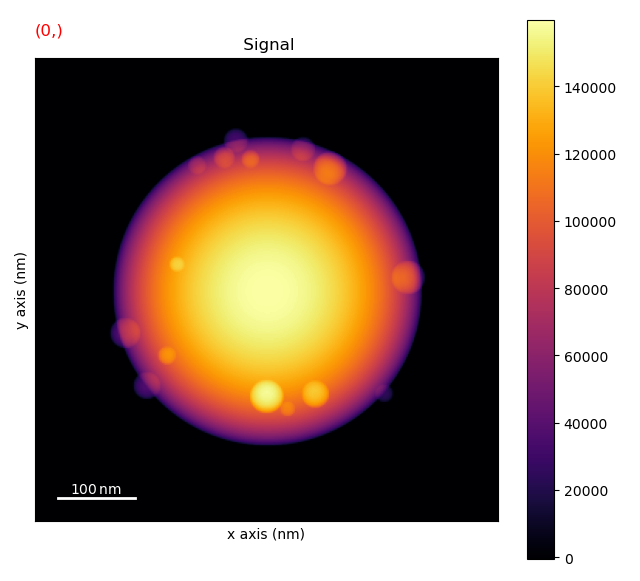

In [101]:
rebin.plot(cmap='inferno')

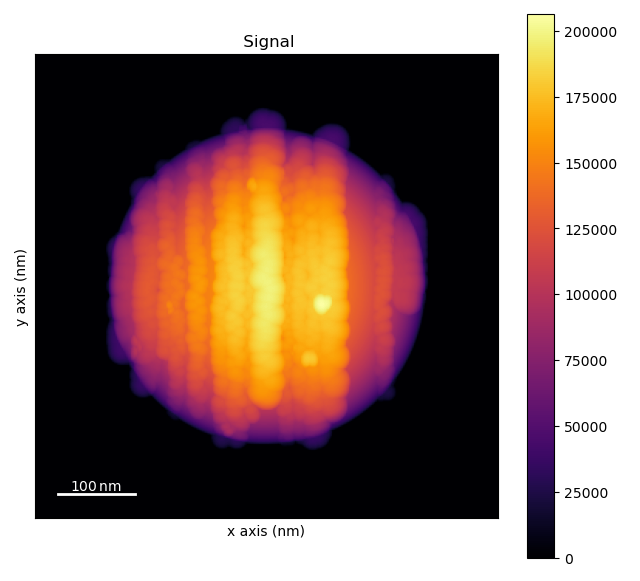

In [102]:
rebin.max().plot(cmap='inferno')

### Stack Registration
* Five methods available:
    * Phase correlation (OpenCV)
    * Enhanced correlation coefficient (OpenCV)
    * StackReg (pystackreg)
    * Center of Mass (T. Sanders et al. doi:10.13140/RG.2.2.33492.60801)
    * Combined Center of Mass and Common-Line Method (UCLA, Scott et al. doi:10.1038/nature10934)

In [103]:
reg = rebin.stack_register('StackReg')

INFO:etspy.align:Performing stack registration using PyStackReg
INFO:etspy.align:Stack registration complete


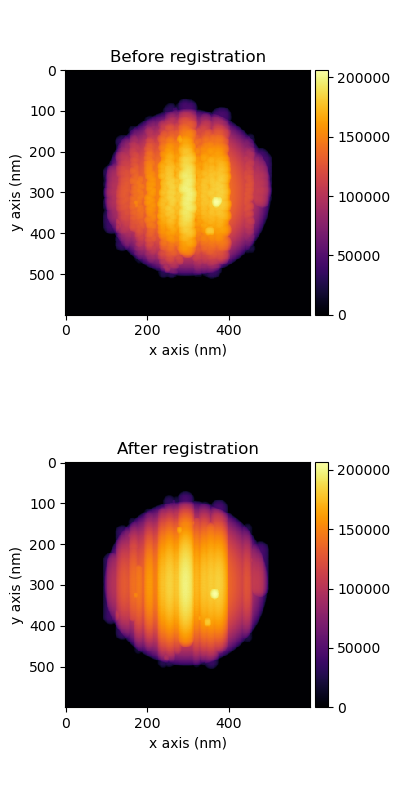

In [104]:
# compare the non-registered and registered max-pixel images:
hs.plot.plot_images(
    [rebin.max(), reg.max()],
    per_row=1,
    label=["Before registration", "After registration"],
    cmap='inferno'
)
plt.gcf().set_size_inches((4,8))
plt.tight_layout()

### Reconstruction

#### Plot single image alongside the sinogram of the central slice

INFO | Hyperspy | <Signal2D, title: , dimensions: (1|300, 90)> data is replaced by its optimized copy, see optimize parameter of ``Basesignal.transpose`` for more information. (hyperspy.signal:4020)


INFO:hyperspy.signal:<Signal2D, title: , dimensions: (1|300, 90)> data is replaced by its optimized copy, see optimize parameter of ``Basesignal.transpose`` for more information.


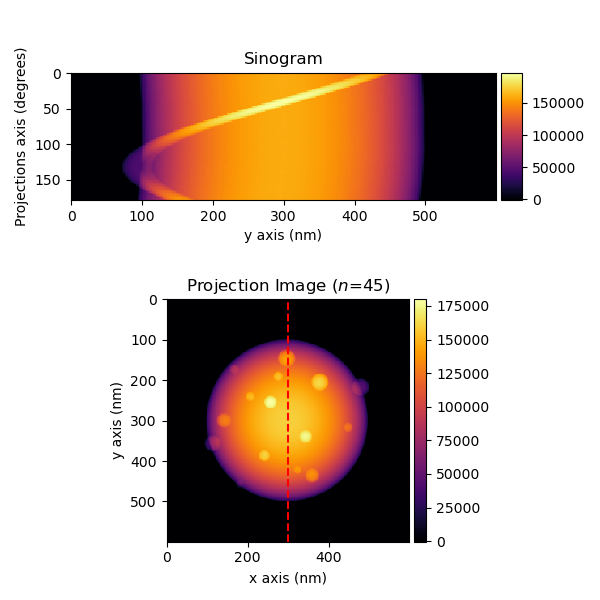

In [105]:
sino = reg.extract_sinogram(150)

ax = hs.plot.plot_images([sino, reg.inav[45]], cmap='inferno', per_row=1, label=['Sinogram','Projection Image ($n$=45)'])
ax[1].axvline(300, linestyle='--', color='red')
plt.gcf().set_size_inches((6,6))
plt.tight_layout()

#### Filtered Backprojection of Single Slice (CPU)

In [106]:
recFBP = reg.isig[150:151, :].reconstruct('FBP', cuda=False)

INFO:etspy.recon:Reconstructing with CPU-based FBP algorithm


[########################################] | 100% Completed | 101.43 ms


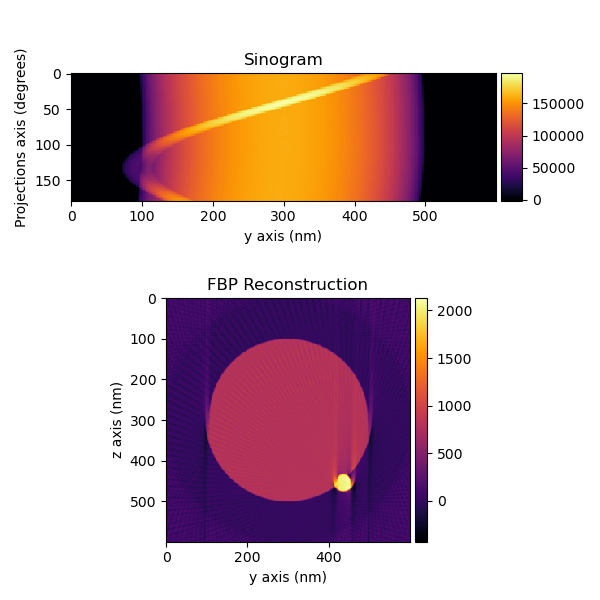

In [107]:
ax = hs.plot.plot_images([sino, recFBP], cmap='inferno', per_row=1, label=['Sinogram','FBP Reconstruction'])
plt.gcf().set_size_inches((6,6))
plt.tight_layout()

#### SIRT Error Analysis
* Perform a SIRT reconstruction and calculate the L2-norm between the forward-projection of each result and the input sinogram
* The reconstruction result is also saved at each iteration for viewing
* Note: Currently, the error output differs between CUDA- and CPU-based reconstructions.  Cause is unknown.

In [108]:
SIRTStack, SIRTerror = reg.isig[150:151, :].recon_error(iterations = 500)
SIRTStack.axes_manager[2].name = 'z'

INFO:etspy.base:CUDA detected with Astra
100%|██████████| 500/500 [00:00<00:00, 961.70it/s]


In [109]:
SIRTStack.plot(navigator=SIRTerror, cmap='inferno')

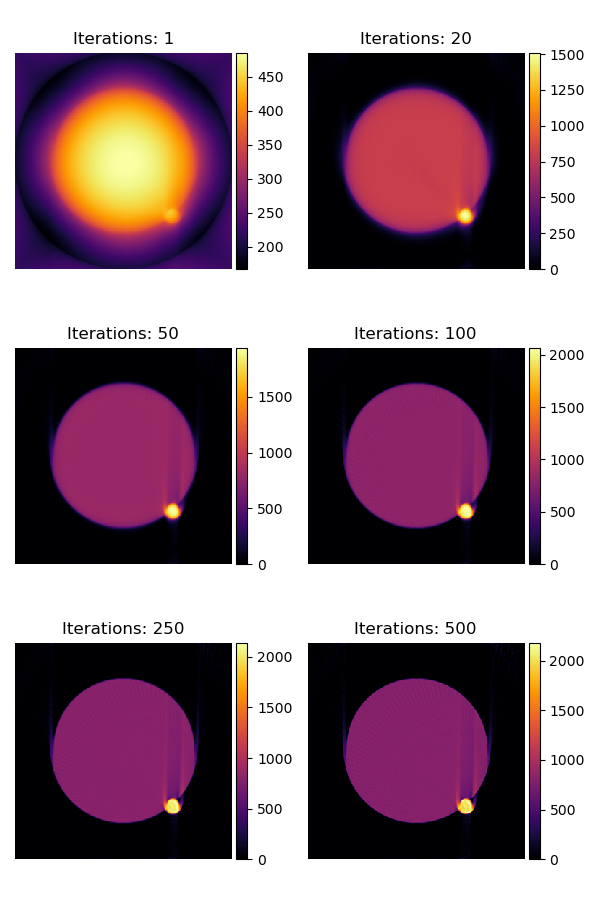

In [110]:
ax = hs.plot.plot_images([SIRTStack.inav[0],SIRTStack.inav[19],SIRTStack.inav[49],
                         SIRTStack.inav[99], SIRTStack.inav[249], SIRTStack.inav[499]],
                         cmap='inferno', per_row=2,
                         axes_decor='off',
                         label=['Iterations: 1','Iterations: 20','Iterations: 50',
                                'Iterations: 100','Iterations: 250','Iterations: 500'])
plt.gcf().set_size_inches(6,9)
plt.tight_layout()

#### Reconstruct the entire binned stack
* Takes less than 30 seconds if using GPU-acceleration (will fail if CUDA tooling not installed)

In [111]:
recFBP = reg.reconstruct('FBP', cuda=True)
recSIRT = reg.reconstruct('SIRT', iterations=100, constrain=True, cuda=True)

INFO:etspy.recon:Reconstructing with CUDA-accelerated FBP algorithm
100%|██████████| 300/300 [00:00<00:00, 1146.55it/s]
INFO:etspy.recon:Reconstructing with CUDA-accelerated SIRT algorithm (100 iterations)
100%|██████████| 300/300 [00:11<00:00, 26.92it/s]


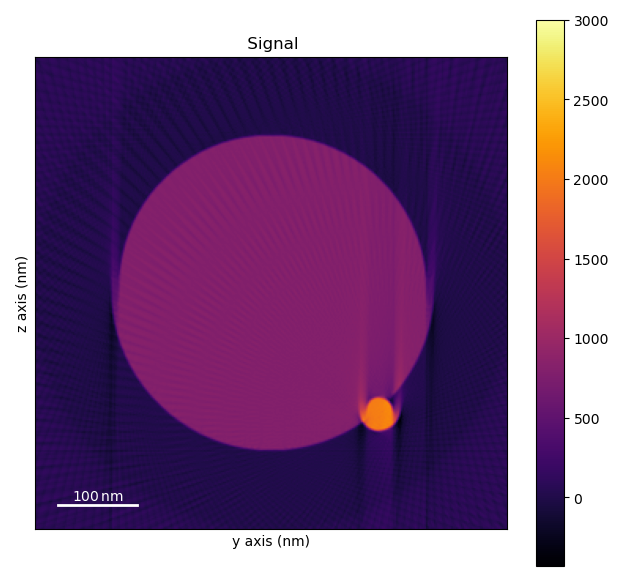

In [143]:
recFBP.inav[150].plot(vmax=3000, cmap='inferno')

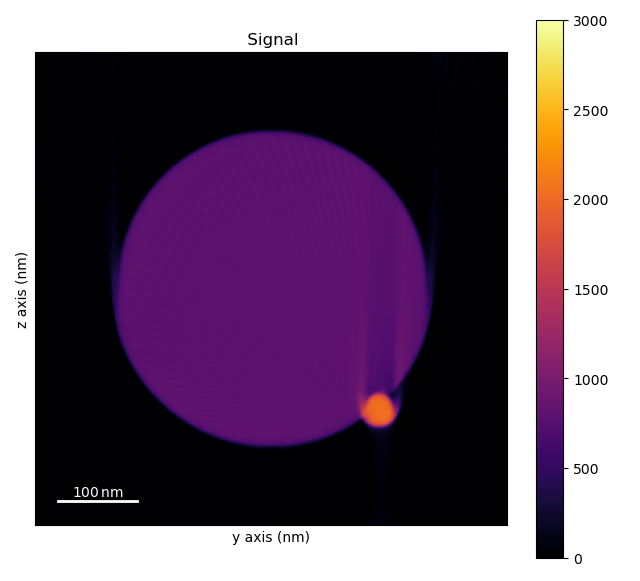

In [144]:
recSIRT.inav[150].plot(vmax=3000, cmap='inferno')

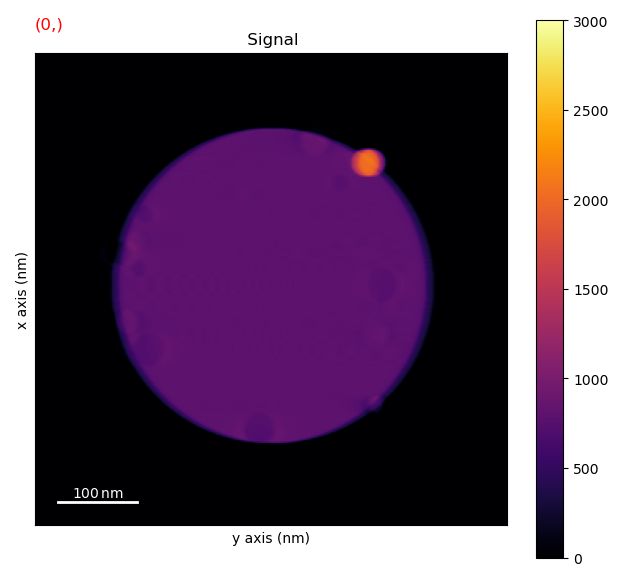

In [138]:
recSIRT.isig[:,150:].swap_axes(0,2).plot(vmax=3000, cmap='inferno')

#### Save the Reconstruction Results
* Hyperspy-compatible HDF5 is the output format

In [23]:
recFBP.save('FBP_Reconstruction.hdf5', overwrite=True, file_format='HSPY')
recSIRT.save('SIRT_Reconstruction_100.hdf5', overwrite=True, file_format='HSPY')

## Experimental Needle-shaped Sample Tilt Series
* FIB-milled specimen from NIST SRM-2135c
    * Ni/Cr mutli-layer thin film on silicon substrate

In [115]:
stack = ds.get_needle_data()

INFO:etspy.io:Tilts found in MRC file header


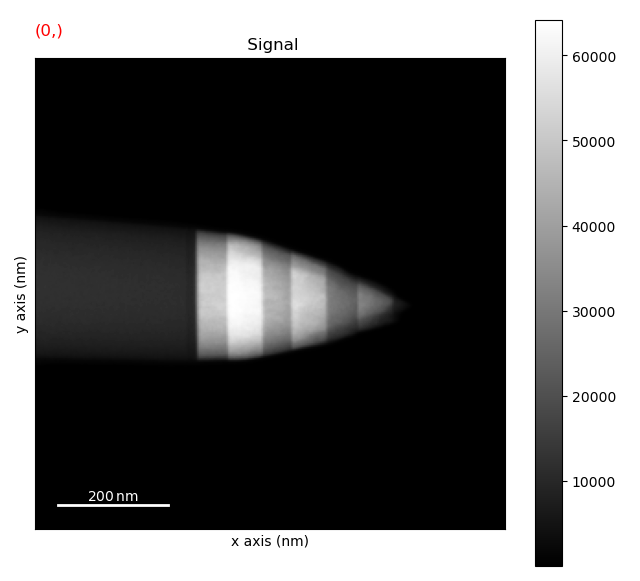

In [116]:
stack.plot(navigator='slider')

### Stack Registration
* Five methods available:
    * Phase correlation (OpenCV)
    * Enhanced correlation coefficient (OpenCV)
    * StackReg (pystackreg)
    * Center of Mass (T. Sanders et al. doi:10.13140/RG.2.2.33492.60801)
    * Combined Center of Mass and Common-Line Method (UCLA, Scott et al. doi:10.1038/nature10934)

In [117]:
reg = stack.stack_register('StackReg')

INFO:etspy.align:Performing stack registration using PyStackReg
INFO:etspy.align:Stack registration complete


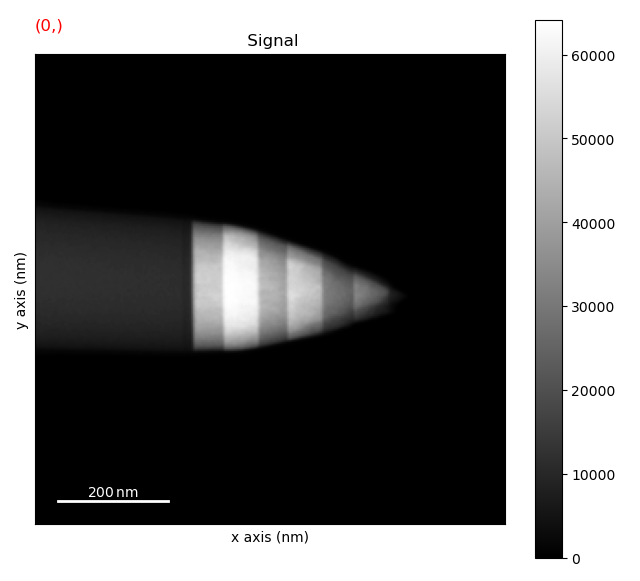

In [118]:
reg.plot(navigator='slider')

INFO:etspy.base:CUDA detected with Astra
INFO:etspy.recon:Reconstructing with CUDA-accelerated FBP algorithm


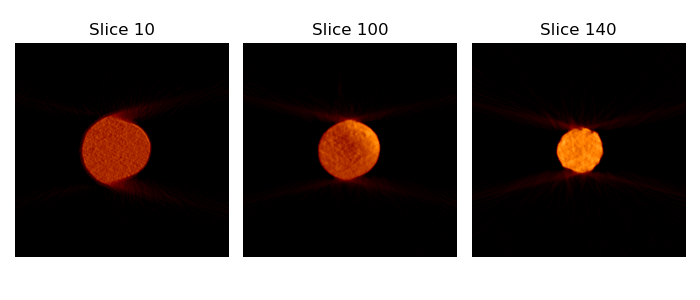

In [119]:
f = reg.test_align(slices=[10,100,140])

### Tilt Axis Alignment
* Uses the center of mass method (CoM)
* Motion of specimen is fit to that expected for an ideal cylinder
* Fit is performed for three different sinograms 
* The result is used to estimate the tilt axis shift and rotation

In [120]:
ali = reg.tilt_align('CoM')

INFO:etspy.align:Performing alignments using best 25 slices
INFO:etspy.align:Calculated tilt-axis shift 0.22
INFO:etspy.align:Calculated tilt-axis rotation -2.74


INFO:etspy.base:CUDA detected with Astra
INFO:etspy.recon:Reconstructing with CUDA-accelerated FBP algorithm


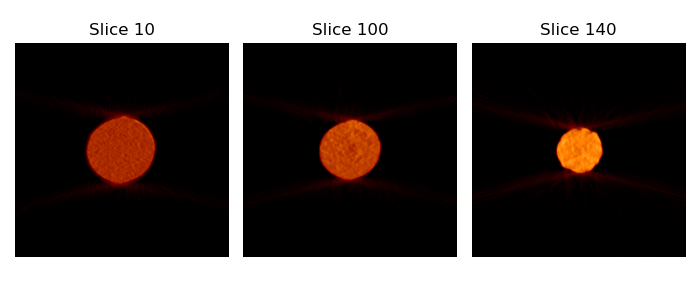

In [121]:
f = ali.test_align(slices=[10,100,140])

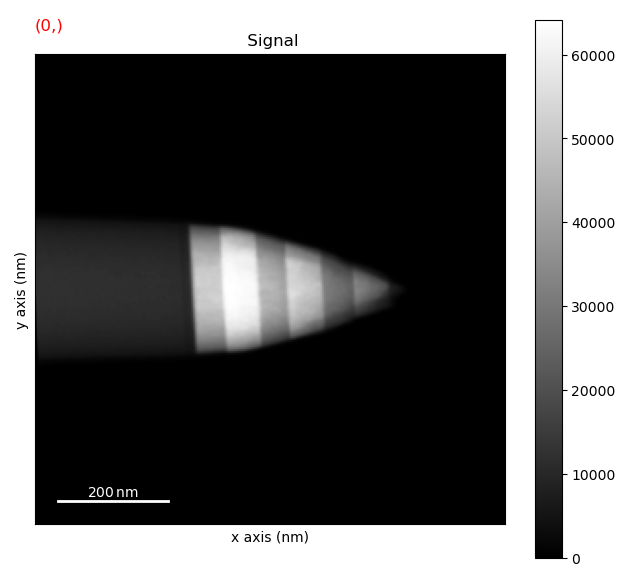

In [122]:
ali.plot()

### Reconstruction

In [123]:
# Takes about a minute on a GPU-accelerated system
rec = ali.reconstruct('SIRT', 500, constrain=True)

INFO:etspy.base:CUDA detected with Astra
INFO:etspy.recon:Reconstructing with CUDA-accelerated SIRT algorithm (500 iterations)
100%|██████████| 256/256 [00:44<00:00,  5.71it/s]


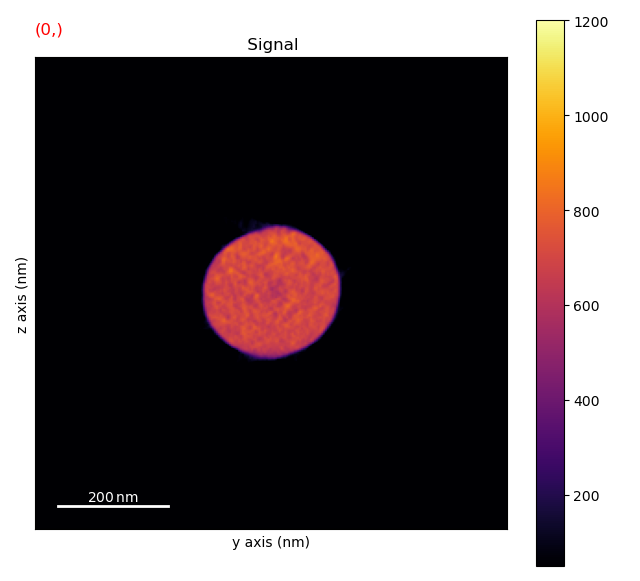

In [127]:
rec.inav[100:205].plot(cmap='inferno', vmin=50, vmax=1200)

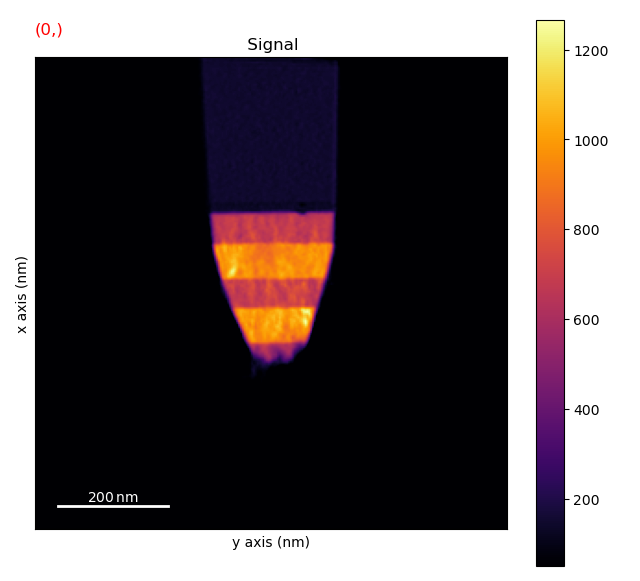

In [129]:
rec.isig[:,110:165].swap_axes(2,0).plot(cmap='inferno', vmin=50)